In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
import numbers
import shap
from sklearn import datasets
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.base import clone
import seaborn as sns
import matplotlib as mpl
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import verify_shap_model, smooth_shap

In [20]:
# Gloabl figure settings
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [3]:
#load JS vis in the notebook for shap plots
shap.initjs() 

In [4]:
# #Import Tree Models from scratch functions
# import sys
# import os

# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path+"/TreeModelsFromScratch")

# from DecisionTree import DecisionTree
# from RandomForest import RandomForest
# from SmoothShap import verify_shap_model, smooth_shap

## Regression

In [5]:
X_dia, y_dia = datasets.load_diabetes(return_X_y=True, as_frame=True)

In [6]:
X_dia.shape

(442, 10)

### Fit random forest model and create explainer

In [7]:
# Train DecisionTree from scratch
reg_forest = RandomForest(n_trees=20, treetype="regression", oob_SHAP=True, random_state=42)
reg_forest.fit(X_dia, y_dia)

export_model_reg = reg_forest.export_forest_for_SHAP()

#import model into shap tree explainer
explainer_reg = shap.TreeExplainer(export_model_reg)

# Verify shap model
verify_shap_model(reg_forest, explainer_reg, X_dia)

In [8]:
# Compute shap scores of RF for train data
shap_vals_rf = explainer_reg.shap_values(X_dia, y_dia)

In [9]:
shap_vals_rf.shape

(442, 10)

## Comparison of raw SHAP, SHAP inbag, SHAP oob & Shrunk SHAP

In [10]:
# Compute smooth shap
reg_smooth_shap_val, reg_smooth_shap_mean, lin_coefs, reg_lin_models, reg_shap_values_inbag, reg_shap_values_oob = smooth_shap(
    reg_forest.inbag_SHAP_values, reg_forest.oob_SHAP_values, detailed_output=True
)

In [11]:
# Lets check if the shape is identical to orignal dataset (each observation should have a smooth shap value)
reg_smooth_shap_val.shape

(442, 10)

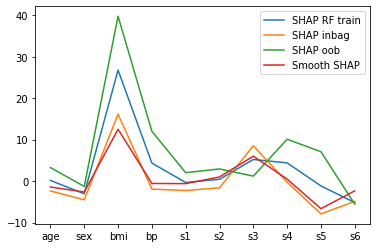

In [12]:
# Lets compare the shap values for the 1st observation
plt.plot(X_dia.columns, shap_vals_rf[0,:], label="SHAP RF train")
plt.plot(X_dia.columns, reg_forest.inbag_SHAP_values[0,:], label="SHAP inbag")
plt.plot(X_dia.columns, reg_forest.oob_SHAP_values[0,:], label="SHAP oob")
plt.plot(X_dia.columns, reg_smooth_shap_val[0,:], label="Smooth SHAP")
plt.legend();

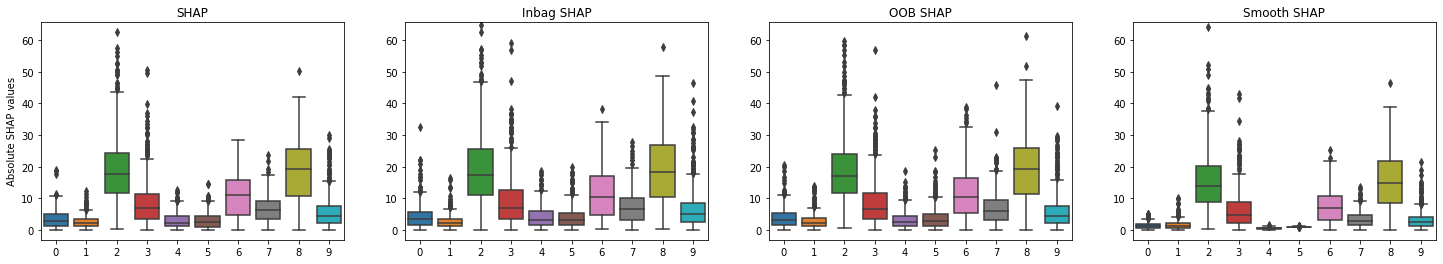

In [13]:
# Comparison of absolute value distribution p feature
fig, axs = plt.subplots(1,4,figsize=(25,4))


sns.boxplot(data=np.abs(shap_vals_rf), ax =axs[0])
sns.boxplot(data=np.abs(reg_forest.inbag_SHAP_values), ax=axs[1])
sns.boxplot(data=np.abs(reg_forest.oob_SHAP_values), ax=axs[2])
sns.boxplot(data=np.abs(reg_smooth_shap_val), ax =axs[3])


axs[0].set_title("SHAP")
axs[1].set_title("Inbag SHAP")
axs[2].set_title("OOB SHAP")
axs[3].set_title("Smooth SHAP")
axs[0].set_ylabel("Absolute SHAP values")
plt.setp(axs, ylim=axs[0].get_ylim());

## Local interpretability of smooth SHAP values

Question remains on how to "interpret" the Smooth SHAP values, as they do not fulfill the accuracy criteria, since base value + sum of smooth SHAP values does not equa the model prediction!?

In [14]:
# Original SHAP force plot for 1st prediction
shap.force_plot(explainer_reg.expected_value, shap_vals_rf[0,:], features=X_dia.iloc[0,:])

In [15]:
# Smooth SHAP force plot
print("Model prediction for 1st observation:", reg_forest.predict(X_dia)[0])
shap.force_plot(explainer_reg.expected_value, reg_smooth_shap_val[0,:], features=X_dia.iloc[0,:])

Model prediction for 1st observation: 183.3


Rescaling formula from Markus new paper:

One way to preserve local accuracy is to scale with this factor:
$$
S_{f,x} = \sum_{j=1}^M{\phi_j(f,x)} / \sum_{j=1}^M{\hat{\beta_j} \cdot \phi_j(f,x) }
$$
leading to
$$
\widehat{SHAP}^{shrunk}_{j, in} = \hat{\beta_j} \cdot \phi_j(f,x) \cdot S_{f,x}
$$

where $\phi_j(f,x) \equiv  SHAP_{j, in}$ would be the "raw", unmodified SHAP score for feature $j$ and input $x$.

Comment: Since Model prediction = base value $+ \sum_{j=1}^M{\phi_j(f,x)}$, this is equivalent to the scaling factor defined below ("Renormalization factor = (Model prediction - base value) / (Sum of smooth SHAP values)")

In [22]:
#rescale_factors = np.divide(shap_vals_rf[0,:], reg_smooth_shap_val[0,:])
rescale_factor_ML = np.sum(shap_vals_rf[0,:])/np.sum(reg_smooth_shap_val[0,:])

In [23]:
# Rescaled Smooth SHAP force plot
print("Model prediction for 1st observation:", reg_forest.predict(X_dia)[0])
shap.force_plot(explainer_reg.expected_value, reg_smooth_shap_val[0,:]*rescale_factor_ML, features=X_dia.iloc[0,:])

Model prediction for 1st observation: 183.3


This rescaling procedure as described by Markus works.
Another way how to rescale the smoothshap values which yields the same results is shown below

In [24]:
# (model_prediction - base value) / (sum(smooth_SHAP_values))
rescale_factorPH = (reg_forest.predict(X_dia)[0]-explainer_reg.expected_value)/reg_smooth_shap_val[0,:].sum()

In [25]:
# Own Rescaled Smooth SHAP force plot
print("Model prediction for 1st observation:", reg_forest.predict(X_dia)[0])
shap.force_plot(explainer_reg.expected_value, reg_smooth_shap_val[0,:]*rescale_factorPH, features=X_dia.iloc[0,:])

Model prediction for 1st observation: 183.3


In [29]:
# Compare both rescale factors 
np.allclose(rescale_factor_ML, rescale_factorPH)

True

## Smooth SHAP for Strobl dataset

Run strobl simulation with regular RF and store SHAP values for each simulation

In [28]:
import os
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","strobl_simulation")

In [1]:
def simulate_data_strobl(n=120, # number of rows in data
                         M=100, # number of simulations
                         relevance = 0.15, # signal srength (0 for NULL)
                         seed=None):
  
    if isinstance(seed, numbers.Integral) or (seed is None):
        random_state = np.random.RandomState(seed)
    elif isinstance(seed, np.random.RandomState):
        random_state = seed

    x1 = random_state.standard_normal(size=(n,M))
    x2 = random_state.randint(1, 3, size=(n,M))
    x3 = random_state.randint(1, 5, size=(n,M))
    x4 = random_state.randint(1, 11, size=(n,M))
    x5 = random_state.randint(1, 21, size=(n,M))
    X = np.array([x1,x2,x3,x4,x5]).T
      
    y = random_state.binomial(n = 1, p = (0.5 + np.array([-1,1])[x2-1]* relevance))

    return X, y

In [6]:
from tqdm import trange

In [9]:
def simulate_data_simple(n=120, M=100, relevance_power=0.15, random_seed=None):
    
    random_state = np.random.RandomState(random_seed)
    
    shap_raw_null = []
    shap_inbag_null = []
    shap_oob_null = []
    shap_sm_null = []

    shap_raw_power = []
    shap_inbag_power = []
    shap_oob_power = []
    shap_sm_power = []
    
    #Null simulation
    X_null, y_null = simulate_data_strobl(n=n, M=M, relevance=0, seed=random_state)   
    #Power simulation
    X_power, y_power = simulate_data_strobl(n=n, M=M, relevance=relevance_power, seed=random_state)
    
    for i in trange(M):
        
        # Null: 
        clf_null_scr = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob_SHAP=True)
        clf_null_scr.fit(X_null[i,:,:], y_null[:,i])

        # Raw shap values
        export_model_scr_null = clf_null_scr.export_forest_for_SHAP()
        explainer_scr_null = shap.TreeExplainer(export_model_scr_null)
        shap_values_scr_null = explainer_scr_null.shap_values(X_null[i,:,:])
        shap_raw_null.append(shap_values_scr_null)

        # Inbag, OOB & Smooth SHap values
        shap_inbag_null.append(clf_null_scr.inbag_SHAP_values)
        shap_oob_null.append(clf_null_scr.oob_SHAP_values)
        smshap_vals_n, _, coefs_smshap_n = smooth_shap(clf_null_scr.inbag_SHAP_values, clf_null_scr.oob_SHAP_values)
        shap_sm_null.append(smshap_vals_n)

        # Power: 
        clf_power_scr = RandomForest(n_trees=100, treetype="classification", random_state=random_seed, oob_SHAP=True)
        clf_power_scr.fit(X_power[i,:,:], y_power[:,i])

        # Raw shap values
        export_model_scr_power = clf_power_scr.export_forest_for_SHAP()
        explainer_scr_power = shap.TreeExplainer(export_model_scr_power)
        shap_values_scr_power = explainer_scr_power.shap_values(X_power[i,:,:])
        shap_raw_power.append(shap_values_scr_power)

        # Inbag, OOB & Smooth SHap values
        shap_inbag_power.append(clf_power_scr.inbag_SHAP_values)
        shap_oob_power.append(clf_power_scr.oob_SHAP_values)
        smshap_vals_p, _, coefs_smshap_p = smooth_shap(clf_power_scr.inbag_SHAP_values, clf_power_scr.oob_SHAP_values)
        shap_sm_power.append(smshap_vals_p)
            
        
    
    results = {
        "simulation_params":
            {"n": n, 
            "M": M, 
            "relevance_power": relevance_power, 
            "random_seed": random_seed},
        "Null":
            {"shap_raw": shap_raw_null,
            "shap_inbag": shap_inbag_null,
            "shap_oob": shap_oob_null,
            "shap_sm": shap_sm_null
            },
        "Power":
            {"shap_raw": shap_raw_power,
            "shap_inbag": shap_inbag_power,
            "shap_oob": shap_oob_power,
            "shap_sm": shap_sm_power
            }}
    
    return results


In [10]:
# Run strobl simulation 
strobl_res = simulate_data_simple(random_seed=42)

100%|██████████| 100/100 [30:20<00:00, 18.21s/it]


In [30]:
# STore results
import pickle 

with open(f'{data_path}/strobl_SHAP_dict.pickle', 'wb') as handle:
    pickle.dump(strobl_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

Create plots

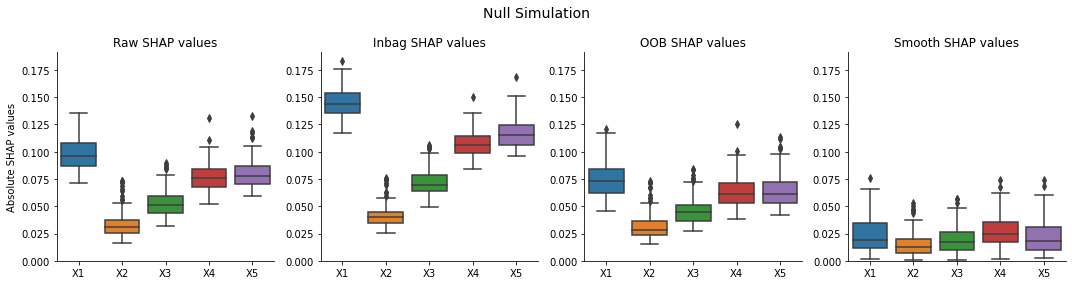

In [46]:
#Null simulation
fig, axs = plt.subplots(1,4, figsize=(15,4))
x_label = ["X1", "X2", "X3", "X4", "X5"]

fig.suptitle('Null Simulation', fontsize=14)

sns.boxplot(data=np.abs(np.array(strobl_res.get("Null").get("shap_raw"))).mean(axis=1), ax=axs[0])
axs[0].set_title('Raw SHAP values')
axs[0].set_ylabel("Absolute SHAP values")

sns.boxplot(data=np.abs(np.array(strobl_res.get("Null").get("shap_inbag"))).mean(axis=1), ax=axs[1])
axs[1].set_title('Inbag SHAP values')

sns.boxplot(data=np.abs(np.array(strobl_res.get("Null").get("shap_oob"))).mean(axis=1), ax=axs[2])
axs[2].set_title('OOB SHAP values')

sns.boxplot(data=np.abs(np.array(strobl_res.get("Null").get("shap_sm"))).mean(axis=1), ax=axs[3])
axs[3].set_title('Smooth SHAP values')

#plt.setp(axs, ylim=[-.02,0.3]) #set global ylim for all suplots
plt.setp(axs, xticks=[0, 1, 2, 3, 4], xticklabels=x_label)
plt.setp(axs, ylim=(0, axs[1].get_ylim()[1]));

fig.tight_layout();
fig.savefig(data_path+"/strobl_shap_boxplot_null_boxplots.pdf");

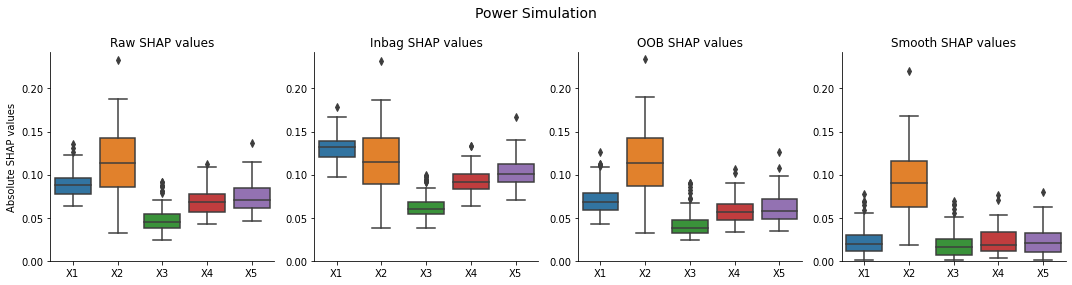

In [45]:
#Power simulation
fig, axs = plt.subplots(1,4, figsize=(15,4))
x_label = ["X1", "X2", "X3", "X4", "X5"]

fig.suptitle('Power Simulation', fontsize=14)

sns.boxplot(data=np.abs(np.array(strobl_res.get("Power").get("shap_raw"))).mean(axis=1), ax=axs[0])
axs[0].set_title('Raw SHAP values')
axs[0].set_ylabel("Absolute SHAP values")

sns.boxplot(data=np.abs(np.array(strobl_res.get("Power").get("shap_inbag"))).mean(axis=1), ax=axs[1])
axs[1].set_title('Inbag SHAP values')

sns.boxplot(data=np.abs(np.array(strobl_res.get("Power").get("shap_oob"))).mean(axis=1), ax=axs[2])
axs[2].set_title('OOB SHAP values')

sns.boxplot(data=np.abs(np.array(strobl_res.get("Power").get("shap_sm"))).mean(axis=1), ax=axs[3])
axs[3].set_title('Smooth SHAP values')

#plt.setp(axs, ylim=[-.02,0.3]) #set global ylim for all suplots
plt.setp(axs, xticks=[0, 1, 2, 3, 4], xticklabels=x_label)
plt.setp(axs, ylim=(0, axs[1].get_ylim()[1]));

fig.tight_layout();

fig.savefig(data_path+"/strobl_shap_boxplot_power_boxplots.pdf");

Create single plots for Markus

Null

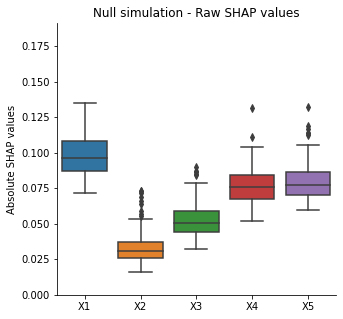

In [41]:
#Create boxplots
fig, axs = plt.subplots(1,1,figsize=(5,5))

sns.boxplot(data=np.abs(np.array(strobl_res.get("Null").get("shap_raw"))).mean(axis=1), ax=axs)
axs.set_title('Null simulation - Raw SHAP values')
axs.set_ylabel("Absolute SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3, 4], xticklabels=x_label)
plt.setp(axs, ylim=(0, 0.191269707188171));

fig.savefig(data_path+"/strobl_shap_boxplot_null_raw.pdf")

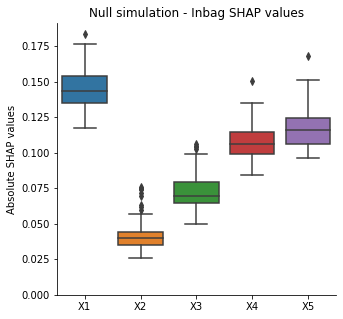

In [42]:
#Create boxplots
fig, axs = plt.subplots(1,1,figsize=(5,5))

sns.boxplot(data=np.abs(np.array(strobl_res.get("Null").get("shap_inbag"))).mean(axis=1), ax=axs)
axs.set_title('Null simulation - Inbag SHAP values')
axs.set_ylabel("Absolute SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3, 4], xticklabels=x_label)
plt.setp(axs, ylim=(0, 0.191269707188171));

fig.savefig(data_path+"/strobl_shap_boxplot_null_inbag.pdf")

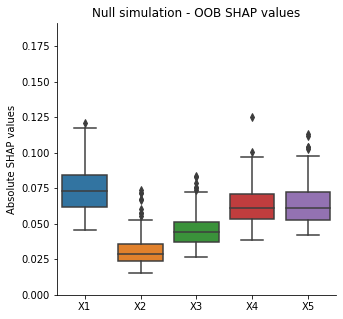

In [43]:
#Create boxplots
fig, axs = plt.subplots(1,1,figsize=(5,5))

sns.boxplot(data=np.abs(np.array(strobl_res.get("Null").get("shap_oob"))).mean(axis=1), ax=axs)
axs.set_title('Null simulation - OOB SHAP values')
axs.set_ylabel("Absolute SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3, 4], xticklabels=x_label)
plt.setp(axs, ylim=(0, 0.191269707188171));

fig.savefig(data_path+"/strobl_shap_boxplot_null_oob.pdf")

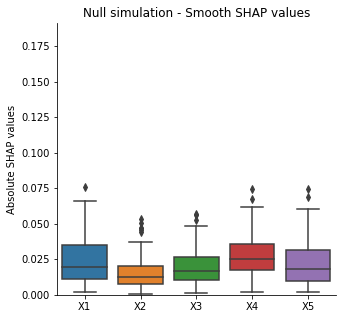

In [44]:
#Create boxplots
fig, axs = plt.subplots(1,1,figsize=(5,5))

sns.boxplot(data=np.abs(np.array(strobl_res.get("Null").get("shap_sm"))).mean(axis=1), ax=axs)
axs.set_title('Null simulation - Smooth SHAP values')
axs.set_ylabel("Absolute SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3, 4], xticklabels=x_label)
plt.setp(axs, ylim=(0, 0.191269707188171));

fig.savefig(data_path+"/strobl_shap_boxplot_null_smooth.pdf")

Power

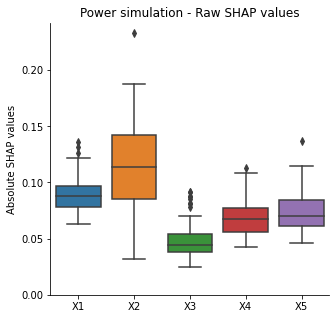

In [32]:
#Create boxplots
fig, axs = plt.subplots(1,1,figsize=(5,5))

sns.boxplot(data=np.abs(np.array(strobl_res.get("Power").get("shap_raw"))).mean(axis=1), ax=axs)
axs.set_title('Power simulation - Raw SHAP values')
axs.set_ylabel("Absolute SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3, 4], xticklabels=x_label)
plt.setp(axs, ylim=(0, 0.2420131023006036));

fig.savefig(data_path+"/strobl_shap_boxplot_power_raw.pdf")

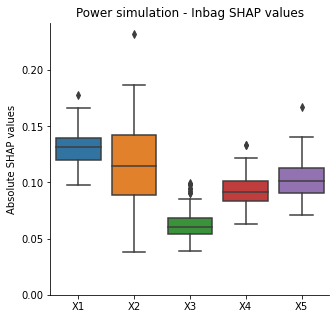

In [33]:
#Create boxplots
fig, axs = plt.subplots(1,1,figsize=(5,5))

sns.boxplot(data=np.abs(np.array(strobl_res.get("Power").get("shap_inbag"))).mean(axis=1), ax=axs)
axs.set_title('Power simulation - Inbag SHAP values')
axs.set_ylabel("Absolute SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3, 4], xticklabels=x_label)
plt.setp(axs, ylim=(0, 0.2420131023006036));

fig.savefig(data_path+"/strobl_shap_boxplot_power_inbag.pdf")

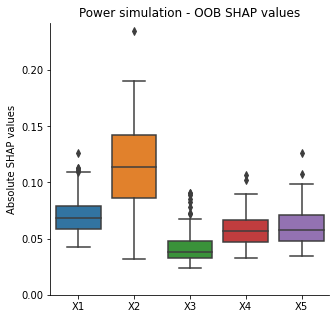

In [34]:
#Create boxplots
fig, axs = plt.subplots(1,1,figsize=(5,5))

sns.boxplot(data=np.abs(np.array(strobl_res.get("Power").get("shap_oob"))).mean(axis=1), ax=axs)
axs.set_title('Power simulation - OOB SHAP values')
axs.set_ylabel("Absolute SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3, 4], xticklabels=x_label)
plt.setp(axs, ylim=(0, 0.2420131023006036));

fig.savefig(data_path+"/strobl_shap_boxplot_power_oob.pdf")

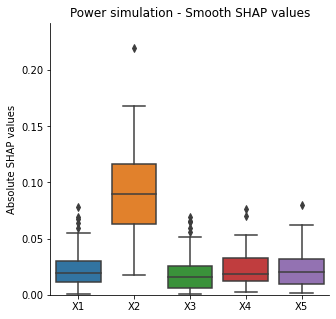

In [35]:
#Create boxplots
fig, axs = plt.subplots(1,1,figsize=(5,5))

sns.boxplot(data=np.abs(np.array(strobl_res.get("Power").get("shap_sm"))).mean(axis=1), ax=axs)
axs.set_title('Power simulation - Smooth SHAP values')
axs.set_ylabel("Absolute SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3, 4], xticklabels=x_label)
plt.setp(axs, ylim=(0, 0.2420131023006036));

fig.savefig(data_path+"/strobl_shap_boxplot_power_smooth.pdf")